# Connectionist temporal classification

## Problem

We have a dataset of audio clips and corresponding transcripts. <br>
We don’t know how the characters in the transcript align to the audio.

### Speech recognition

<img src="./data/speech_recognition.svg" width="500">

### Handwritting recognition

<img src="./data/handwriting_recognition.svg" width="500">

### Alignment

CTC works by summing over the probability of all possible alignments between an input and an output. Assume the input has length six and $Y = [c, a, t]$. One way to align $X$ and $Y$ is to assign an output character to each input step and collapse repeats.

<img src="./data/naive_alignment.svg" width="500">

Problems of this approach: <br>
1) it doesn’t make sense to force every input step to align to some output: for example, silence in speech recognition; <br>
2) collapsing repeats will produce “helo” instead of “hello”. <br>

To get around these problems, CTC introduces a blank token to the set of allowed outputs.

<img src="./data/ctc_alignment_steps.svg" width="500">

Let’s go back to the output $[c, a, t]$ with an input of length six. Here are a few more examples of valid and invalid alignments.

<img src="./data/valid_invalid_alignments.svg" width="500">

### From Network Outputs to Labellings

For an input sequence $x$ of length $T$, define a recurrent neural network $\mathcal{N}_w$. Let $y = \mathcal{N}_w(x)$ be the sequence of network outputs, and denote by $y_k^t$ the activation of output unit $k$ at time t. Then $y_k^t$ is interpreted as the probability of observing label k at time t, which defines a distribution over the alphabet $L'^T$ of length T sequences over the alphabet $L' = L \cup \{blank\}$:

$$ p(\pi | x) = \prod_{t = 1}^T y_{\pi_t}^t, \forall \pi \in L'^T $$

We refer to the elements of $L'^T$ as paths, and denote them $\pi$.<br><br>
The network outputs at different times are **conditionally independent**. Also a CTC network has a **softmax** output layer along time axis.

Define a map $\mathcal{B} : L'^T \to L'^{\le T}$. This map simply removes all blanks and repeated labels from the paths (e.g. $\mathcal{B}(a−ab−) = \mathcal{B}(−aa−−abb) = aab$). Finally define a the conditional probability of a given labelling $l \in L'^{\le T}$:

$$ p(l | x) = \sum_{\pi \in \mathcal{B}^{−1}(l)} p(\pi | x)$$

<img src="./data/full_collapse_from_audio.svg" width="500">

### Constructing the Classifier

The output of the classifier should be the most probable labelling for the input sequence:


$$ h(x) = \underset{l \in L^{\le T}}{\operatorname{argmax}} p(l|x) $$

One method (best path decoding) is based on the assumption that the most probable path will corre spond to the most probable labelling:

$$ h(x) \approx \mathcal{B}(\pi^∗), \quad \textrm{where} \quad π^∗ = \underset{\pi}{\operatorname{argmax}} p(\pi | x) $$

Best path decoding is trivial to compute, however it is not guaranteed to find the most probable labelling.

### The CTC Forward-Backward Algorithm

We require an efficient way of calculating the conditional probabilities $p(l | x)$ of individual labellings. There is a problem: very many of paths corresponding to a given labelling. Fortunately the problem can be solved with a dynamic programming algorithm.

For some sequence $q$ of length $r$, denote by $q_{1:p}$ and $q_{r−p:r}$ its first and last p symbols respectively. Then for a labelling $l$, define the forward variable $\alpha_t(s)$ to be the total probability of $l_{1:s}$ at time $t$:

$$ \alpha_t(s) \overset{def}{\operatorname{=}} \sum_{\pi : \mathcal{B}(\pi_{1:t}) = l_{1:s}} \prod_{t' = 1}^t y_{\pi_{t'}}^{t'} $$


As we will see, $\alpha_t(s)$ can be calculated recursively.

To allow for blanks in the output paths, we consider a modified label sequence $l'$, with blanks added to the beginning and the end and inserted between every pair of labels:

$$ l' = (b, l_1, b, l_2, \dots, l_k, b), \quad \textrm{where} \quad k = |l|, \quad b - \textrm{blank symbol}$$

We allow all transitions between blank and non-blank labels, and also those between any pair of distinct non-blank labels. We allow all prefixes to start with either $b$ or $l_1$.

<img src="./data/ctc_cost.svg" width="500">

Now we have the following rules for initialisation

$$ \alpha_1(1) = y_b^1 $$
$$ \alpha_1(2) = y_{l_1}^1 $$
$$ \alpha_1(s) = 0, \forall s > 2 $$

And now we need to recursively define $\alpha_{t}(s)$. There is to cases.

In first case, we can’t jump over $l'_{s-1}$, the previous token. The first reason is that the previous token can be an element of $L$. The second reason is that we must have a blank between repeat characters from $L$.

<img src="./data/cost_no_skip.svg" width="200">

$$ \alpha_t(s) = (\alpha_{t − 1}(s) + \alpha_{t − 1}(s - 1)) y_{l'_s}^t \quad \textrm{if} \quad l'_s = b \lor l'_s = l'_{s - 2} $$

In second case, we allowed to skip the previous token.

<img src="./data/cost_regular.svg" width="200">

$$ \alpha_t(s) = (\alpha_{t − 1}(s) + \alpha_{t − 1}(s - 1) + \alpha_{t − 1}(s - 2)) y_{l'_s}^t $$

The probability of $l$ is then the sum of the total probabilities of $l'$ with and without the final blank at time $T$:

$$ p(l | x) = \alpha_T(|l'|) + \alpha_T(|l'| − 1) $$

Similarly define backward variables $\beta_t(s)$:

$$ \beta_t(s) \overset{def}{\operatorname{=}} \sum_{\pi : \mathcal{B}(\pi_{t:T}) = l_{s:|l|}} \prod_{t' = t}^T y_{\pi_{t'}}^{t'} $$

### Maximum Likelihood Training

The aim of maximum likelihood training is to simultaneously maximise the log probabilities of all the correct classifications in the training set. In our case, this means minimising the following objective function:

$$ \mathcal{O}^{ML}(S, \mathcal{N}_w) = - \sum_{(x, z) \in S} ln(p(z | x)) $$

To train the network with gradient descent, we need to differentiate $\mathcal{O}$ with respect to the network outputs:

$$ \frac{\partial \mathcal{O}^{ML}(\{(x, z)\}, \mathcal{N}_w)}{\partial y_k^t} = - \frac{\partial ln(p(z | x))}{\partial y_k^t}$$

The key point is that, for a labelling $l$, the product of the forward and backward variables at a given $s$ and
$t$ is the probability of all the paths corresponding to $l$ that go through the symbol $s$ at time $t$:

$$ \alpha_t(s) \beta_t(s) = \sum_{\pi \in \mathcal{B}^{-1}(l) : \pi_t = l_s} y_{l_s}^t \prod_{t' = 1}^T y_{\pi_t'}^{t'} $$

or

$$ \frac{\alpha_t(s) \beta_t(s)}{y_{l_s}^t} = \sum_{\pi \in \mathcal{B}^{-1}(l) : \pi_t = l_s} p(\pi | x) $$

Now we can sum over all $s$ and $t$:

$$ p(l | x) = \sum_{t = 1}^T \sum_{s = 1}^{|l|} \frac{\alpha_t(s) \beta_t(s)}{y_{l_s}^t} $$

Because the network outputs are conditionally independent, we need only consider the paths going through label $k$ at time $t$ to get partial derivatives. Same label may be repeated several times, so we define the set of positions where $k$ occurs as $lab(l, k) = \{ s : l_s = k \}$:

$$ \frac{\partial p(l | x)}{\partial y_{l_s}^t} = - \frac{1}{(y_{l_s}^t)^2} \sum_{s \in lab(l, k) = 1} \alpha_t(s) \beta_t(s) $$

and

$$ \frac{\partial ln(p(l | x))}{\partial y_{l_s}^t} = \frac{1}{p(l | x)} \frac{\partial p(l | x)}{\partial y_{l_s}^t} $$

so we can compute $ \mathcal{O}^{ML}(S, \mathcal{N}_w) $.

In practice, the above recursions will soon lead to underflows on any digital computer. Way of avoiding this with rescaling the forward and backward variables described in original paper.

### Using CTC loss in tensorflow

In [1]:
import cv2
import numpy as np
import IPython

def imshow(img):
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

def generate_sample(max_symbols, alphabet):
    sym_h, sym_w = 20, 20
    alphabet = list(alphabet)
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    image = np.zeros((sym_h, sym_w * max_symbols), dtype=np.uint8)
    sequence = [np.random.choice(alphabet) for _ in range(np.random.randint(max_symbols))]
    sequence_prefix = [' ' for _ in range(np.random.randint(max_symbols - len(sequence)))]
    sequence_postfix = [' ' for _ in range(max_symbols - len(sequence) - len(sequence_prefix))]
    sequence_str = ''.join(sequence_prefix + sequence + sequence_postfix)

    sequence = np.array(
        [alphabet.index(c) for c in sequence] +
        (max_symbols - len(sequence)) * [len(alphabet)])
    cv2.putText(image, sequence_str, (0, sym_h), font, 0.8, (255), 2, cv2.LINE_AA)
    
    return image, sequence

In [2]:
# model constant
max_sequence_length = 10
alphabet = '0123456789'
image_size = 20, 20 * max_sequence_length

image, sequence = generate_sample(max_sequence_length, alphabet)
imshow(image)
print(sequence)

[ 1  7  3 10 10 10 10 10 10 10]


### Lets define a model!

In [3]:
import os
import tensorflow as tf
import warnings

tf.logging.set_verbosity(tf.logging.ERROR)

inputs = tf.placeholder(shape=(None, image_size[0], image_size[1], 1), dtype=tf.float32)
targets = tf.placeholder(shape=(None, max_sequence_length), dtype=tf.int32)

In [4]:
def conv_block(inp, filters):
    x = tf.layers.conv2d(inputs=inp, filters=filters,
                         kernel_size=3, padding='same',
                         activation='relu', kernel_initializer='he_normal')
    x = tf.layers.dropout(inputs=x, rate=0.5)
    x = tf.layers.max_pooling2d(inputs=x, pool_size=2,
                                strides=2, padding='same')
    return x

x = conv_block(inputs, 16)
x = conv_block(x, 32)
x = conv_block(x, 64)

x

<tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(?, 3, 25, 64) dtype=float32>

In [5]:
fh, fw, fc = x.get_shape()[1:]

x = tf.transpose(x, (0, 2, 1, 3))
x = tf.reshape(x, [-1, fw, fh * fc])

x

<tf.Tensor 'Reshape:0' shape=(?, 25, 192) dtype=float32>

In [6]:
import tensorflow.contrib.rnn as rnn
from tensorflow.python.ops import array_ops

cell_fw = tf.nn.rnn_cell.GRUCell(
    num_units=32,
    activation=tf.nn.tanh,
    name='fw')
cell_bw = tf.nn.rnn_cell.GRUCell(
    num_units=32,
    activation=tf.nn.tanh,
    name='bw')

x_batch_size = array_ops.shape(x)[0]

x = tf.unstack(x, axis=1)
outputs = rnn.static_bidirectional_rnn(
    cell_fw=cell_fw, cell_bw=cell_bw,
    initial_state_fw=cell_fw.zero_state(x_batch_size, dtype=tf.float32),
    initial_state_bw=cell_bw.zero_state(x_batch_size, dtype=tf.float32),
    inputs=x)[0]
x = tf.stack(outputs, axis=1)

x

<tf.Tensor 'stack:0' shape=(?, 25, 64) dtype=float32>

In [7]:
eos = len(alphabet)

logits_model = tf.layers.dense(
    inputs=x,
    units=len(alphabet) + 1,
    kernel_initializer='he_normal')

target_length = tf.count_nonzero(
    tf.not_equal(targets, eos),
    axis=1,
    dtype=tf.int32)
logit_length = tf.tile(
    input=[array_ops.shape(logits_model)[1]],
    multiples=[array_ops.shape(logits_model)[0]])
logits_model_t = tf.transpose(logits_model, perm=(1, 0, 2))

probas_model = tf.nn.softmax(logits_model, axis=2)

logits_model_t

<tf.Tensor 'transpose_1:0' shape=(25, ?, 11) dtype=float32>

In [8]:
# predictions
[sparse_decoded], _ = tf.nn.ctc_greedy_decoder(
    inputs=logits_model_t,
    sequence_length=logit_length)
model_preds = tf.sparse.to_dense(sp_input=sparse_decoded,
                                 default_value=eos)

# loss
ctc_loss = tf.nn.ctc_loss_v2(labels=targets,
                             logits=logits_model_t,
                             label_length=target_length,
                             logit_length=logit_length,
                             blank_index=eos)
model_loss = tf.reduce_mean(ctc_loss)

### Now we can train our model

In [9]:
def generate_batch(batch_size):
    h, w = image_size
    batch_images = np.zeros(
        (batch_size, h, w, 1), dtype=np.uint8)
    batch_sequences = np.zeros(
        (batch_size, max_sequence_length), dtype=np.uint8)
    for idx in range(batch_size):
        image, sequence = generate_sample(
            max_sequence_length, alphabet)
        image = cv2.resize(image, (w, h))
        batch_images[idx] = np.expand_dims(image, axis=2)
        batch_sequences[idx] = sequence
    return batch_images, batch_sequences

images, sequences = generate_batch(32)
images.shape, sequences.shape

((32, 20, 200, 1), (32, 10))

In [10]:
train_op = tf.contrib.layers.optimize_loss(
    model_loss, tf.train.get_global_step(),
    optimizer='Adam', learning_rate=0.001)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [11]:
for e in range(5):
    for _ in range(100):
        images, sequences = generate_batch(128)
        sess.run([train_op], feed_dict={
            inputs: images / 256.,
            targets: sequences})

    images, sequences = generate_batch(8)
    loss, preds = sess.run([model_loss, model_preds],
                           feed_dict={
                               inputs: images / 256.,
                               targets: sequences})
    print('Epoch {} loss: {}'.format(e + 1, loss))
    print('Predicted: {}'.format(preds[0]))
    print('Sequence:  {}'.format(sequences[0]))

Epoch 1 loss: 15.891048431396484
Predicted: []
Sequence:  [ 2  6  8  1  1  6 10 10 10 10]
Epoch 2 loss: 5.327726364135742
Predicted: [ 4  7  6 10]
Sequence:  [ 4  3  8  7  6 10 10 10 10 10]
Epoch 3 loss: 1.6848082542419434
Predicted: [ 0  3  0  6 10 10 10 10 10]
Sequence:  [ 0  3  0  6 10 10 10 10 10 10]
Epoch 4 loss: 0.5470319986343384
Predicted: [ 4 10 10 10 10 10 10 10 10]
Sequence:  [ 4 10 10 10 10 10 10 10 10 10]
Epoch 5 loss: 0.37221187353134155
Predicted: [ 7  7 10 10 10 10]
Sequence:  [ 7  7 10 10 10 10 10 10 10 10]


In [12]:
from itertools import product

def probas_to_image(proba):
    cell_size = 10, 10
    t, k = proba.shape[:2]
    canvas = np.zeros(
        (cell_size[0] * k, cell_size[1] * t),
        dtype=np.uint8)
    for tt, kk in product(range(t), range(k)):
        canvas[cell_size[0]*kk:cell_size[0]*(kk+1),
               cell_size[1]*tt:cell_size[1]*(tt+1)] = int(255 * proba[tt][kk])
    return canvas

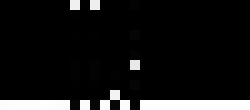

(array([[0, 0, 9, 6]]), (25, 11))

In [14]:
images, sequences = generate_batch(1)
loss, preds, probas = sess.run(
    [model_loss, model_preds, probas_model],
    feed_dict={
        inputs: images / 256.,
        targets: sequences})
image = np.squeeze(images)
proba = np.squeeze(probas)

imshow(image)
imshow(probas_to_image(proba))

preds, proba.shape

### References

1. Connectionist Temporal Classification : Labelling Unsegmented Sequence Data with Recurrent Neural Networks
Graves, A., Fernandez, S., Gomez, F. and Schmidhuber, J., 2006 (ftp://ftp.idsia.ch/pub/juergen/icml2006.pdf) <br>
2. Sequence Modeling With CTC (https://distill.pub/2017/ctc/) <br>
3. https://www.tensorflow.org/api_docs/python/tf/nn/ctc_loss_v2